In [ ]:
# standard libraries
import os
from datetime import datetime
from collections import defaultdict

# data science libraries
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score

# google libraries
from google.colab import drive

# mount data from my google drive
drive.mount('/content/gdrive')
os.chdir('/content/gdrive/My Drive/secure-cloud-computation')

DEGREE = 14
MAX_DEPTH = 4

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
def csv_to_vector(file_name):
  '''
  pull data from a csv file and coverst to timestamp vector
  and performance vector
  return (timestamp vector, performance vector)
  '''
  df = pd.read_csv(file_name, low_memory=False)
  df_binary = df[['(PDH-CSV 4.0) (Pacific Daylight Time)(420)', 
                  '\\\LAPTOP-BSJ64FR3\Memory\% Committed Bytes In Use', 
                  '\\\LAPTOP-BSJ64FR3\Processor Information(_Total)\% Processor Performance']]
  # Taking only the selected two attributes from the dataset
  df_binary.columns = ['date_time', 'memory_pct', 'total_cpu_pct']

  row_size = df_binary['date_time'].size

  for i in range(df_binary['memory_pct'].size):
    df_binary.loc[i, 'memory_pct'] = np.float64(df_binary.loc[i, 'memory_pct'])

  for i in range(df_binary['total_cpu_pct'].size):
    if df_binary.loc[i, 'total_cpu_pct'] == " ":
      df_binary.loc[i, 'total_cpu_pct'] = np.float64(0)
    else:
      df_binary.loc[i, 'total_cpu_pct'] = np.float64(df_binary.loc[i, 'total_cpu_pct'])

  #process date time
  processed_date_time = np.zeros(row_size)
  for i in range(row_size):
    datetime_str = df_binary.loc[i, 'date_time']
    datetime_object = datetime.strptime(datetime_str, '%m/%d/%Y %H:%M:%S.%f')
    processed_date_time[i] = datetime_object.weekday() * 24 + datetime_object.hour 

  total_ram_cpu_performance = np.zeros(row_size)
  for i in range(row_size):
    total_ram_cpu_performance[i] = df_binary.loc[i, 'memory_pct'] + df_binary.loc[i, 'total_cpu_pct']
    
  # Taking only the selected two attributes from the dataset
  #df_binary.columns = ['date_time', 'memory_pct', 'total_cpu_pct']
  #display the first 5 rows
  df_binary.head()
  return (processed_date_time, total_ram_cpu_performance)

#processed_date_time, total_ram_cpu_performance = csv_to_vector('data-collector-1.csv')
# init
final_processed_timestamp, final_processed_performance = np.zeros(0), np.zeros(0)
files = ['data-collector-1.csv', 'data-collector-2.csv', 'data-collector-3.csv']
#files = ['data-collector-1.csv']
for a_file in files:
  a_processed_timestamp, a_processed_performance = csv_to_vector(a_file)
  # update the final vectors
  final_processed_timestamp = np.concatenate((final_processed_timestamp, a_processed_timestamp))
  final_processed_performance = np.concatenate((final_processed_performance, a_processed_performance))

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [ ]:
# train the model using the regression model
# provided by scikit learn
up_X = final_processed_timestamp.reshape(-1, 1)
up_y = final_processed_performance.reshape(-1, 1)

time_count_dict = defaultdict(int)
for i in up_X:
  time_count_dict[i[0]] += 1
frequency_array = np.array(list(time_count_dict.values()))
average_occurance = np.average(frequency_array)
total_up_occurance = np.sum(frequency_array)
up_times = len(time_count_dict.keys())

# calculate the up times each day
# calculate the down timestamps for each day
# calculate the average down time for each down timestamp

# {day: up frequency}
up_time_per_day_count = defaultdict(int)
for a_timestamp, freq in time_count_dict.items():
  day = int(a_timestamp / 24)
  up_time_per_day_count[day] += freq

# {day: [down timestamps]}
down_timestamp_per_day = defaultdict(list)
for a_timestamp in range(24 * 7):
  if a_timestamp not in time_count_dict:
    day = int(a_timestamp / 24)
    down_timestamp_per_day[day].append(a_timestamp)

improved_no_up_times = []
for day, timestamp_list in down_timestamp_per_day.items():
  avg_per_day = int(up_time_per_day_count[day] / len(down_timestamp_per_day[day]))
  for a_timestamp in timestamp_list:
    for i in range(avg_per_day):
      improved_no_up_times.append(a_timestamp)
improved_no_up_X = np.array(improved_no_up_times).reshape(-1, 1)
improved_no_up_y = np.zeros(improved_no_up_X.size).reshape(-1, 1)
X = np.concatenate((up_X, improved_no_up_X))
y = np.concatenate((up_y, improved_no_up_y))

# shuffle the data
X, y = shuffle(X, y, random_state=0)
# split data into train data and test
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.80)

# previous impl
'''
average_no_up_occurance = int(total_up_occurance / (7 * 24 - up_times))
print(average_occurance, average_no_up_occurance)
no_up_times = [float(i) for i in range(7 * 24) if i not in time_count_dict] * average_no_up_occurance
print(len(no_up_times), len(up_X))
no_up_X = np.array(no_up_times).reshape(-1, 1)
no_up_y = np.zeros(no_up_X.size).reshape(-1, 1) 

X = np.concatenate((up_X, no_up_X))
y = np.concatenate((up_y, no_up_y))
'''

# polynomial regression model train
scaler = preprocessing.StandardScaler()
polyreg=make_pipeline(PolynomialFeatures(DEGREE), scaler, LinearRegression())
polyreg.fit(X_train, y_train)

# decision tree regression train
rng = np.random.RandomState(1)
clf = AdaBoostRegressor(DecisionTreeRegressor(max_depth=MAX_DEPTH), n_estimators=300, random_state=rng)
#clf = DecisionTreeRegressor(max_depth=9)
clf = clf.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


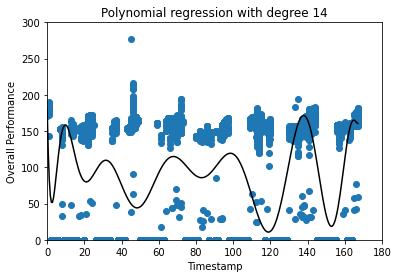

In [ ]:
# draw the data scatter plot and our 
# trained model
fig, ax = plt.subplots(1, 1)
ax.scatter(X_train, y_train)
ax.set_xlim(0,180)
ax.set_ylim(0,300)

X_seq = np.linspace(X_train.min(),X_train.max(),300).reshape(-1,1)
ax.plot(X_seq,polyreg.predict(X_seq),color="black")
#ax.plot(X_seq,clf.predict(X_seq),color="m")

plt.title("Polynomial regression with degree "+str(DEGREE))
plt.xlabel("Timestamp")
plt.ylabel("Overall Performance")
plt.show()


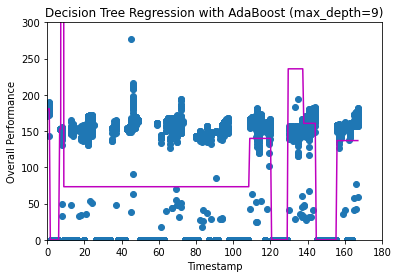

In [ ]:
# draw the data scatter plot and our 
# trained model
fig, ax = plt.subplots(1, 1)
ax.scatter(X_train, y_train)
ax.set_xlim(0,180)
ax.set_ylim(0,300)

X_seq = np.linspace(X_train.min(),X_train.max(),300).reshape(-1,1)
#ax.plot(X_seq,polyreg.predict(X_seq),color="black")
ax.plot(X_seq,clf.predict(X_seq),color="m")

plt.title("Decision Tree Regression with AdaBoost (max_depth=9)")
plt.xlabel("Timestamp")
plt.ylabel("Overall Performance")
plt.show()

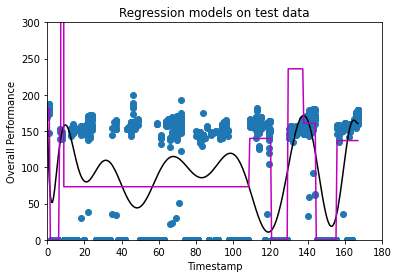

In [ ]:
# draw the data scatter plot and our 
# trained model
fig, ax = plt.subplots(1, 1)
ax.scatter(X_test, y_test)
ax.set_xlim(0,180)
ax.set_ylim(0,300)

X_seq = np.linspace(X_train.min(),X_train.max(),300).reshape(-1,1)
ax.plot(X_seq,polyreg.predict(X_seq),color="black")
ax.plot(X_seq,clf.predict(X_seq),color="m")

plt.title("Regression models on test data")
plt.xlabel("Timestamp")
plt.ylabel("Overall Performance")
plt.show()

In [ ]:
print("TRAIN REPORT")
print("---------------------------------------------")
y_poly_train_pred = polyreg.predict(X_train)
poly_train_rmse = np.sqrt(mean_squared_error(y_train,y_poly_train_pred))
print("Polyreg train rmse: ", poly_train_rmse)
y_poly_test_pred = polyreg.predict(X_test)
poly_test_rmse = np.sqrt(mean_squared_error(y_test,y_poly_test_pred))
print("Polyreg test rmse: ", poly_test_rmse)
print("---------------------------------------------")
y_tree_train_pred = clf.predict(X_train)
tree_train_rmse = np.sqrt(mean_squared_error(y_train,y_tree_train_pred))
print("Decision tree train rmse: ", tree_train_rmse)
y_tree_test_pred = clf.predict(X_test)
tree_test_rmse = np.sqrt(mean_squared_error(y_test,y_tree_test_pred))
print("Decision tree test rmse: ", tree_test_rmse)

TRAIN REPORT
---------------------------------------------
Polyreg train rmse:  730.2672722779898
Polyreg test rmse:  628.2100408609804
---------------------------------------------
Decision tree train rmse:  731.3596704782888
Decision tree test rmse:  670.2063945040342
